Instalação das bibliotecas

In [1]:
%pip install -q google-genai
%pip install -q google-adk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.1/232.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.1/334.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0

importações e constantes

In [2]:
import os
from google import genai #genai
from IPython.display import HTML, Markdown #formatação de exibição
from typing import Final #criar constantes
from PIL import Image #mostrar imagens
from io import BytesIO #utilizado no método que mostra imagem
from google.adk.agents import Agent #abstração de agente
from google.adk.runners import Runner #quem vai rodar o agente
from google.adk.sessions import InMemorySessionService #memória do runner
from google.adk.tools import google_search #ferramenta do google search
from datetime import date
from google.genai import types
from google.colab import userdata

MODEL_GEMINI_TEXT: Final = 'gemini-2.0-flash'
MODEL_GEMINI_IMAGE_GENERATION: Final = 'gemini-2.0-flash-preview-image-generation'
USER_ID: Final = 'user1'
SESSION_ID: Final = 'session1'

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')



Métodos

In [10]:
def processar_imagem(response):
  if not response.candidates:
    print("Nenhum candidato encontrado na resposta.")
  else:
    for part in response.candidates[0].content.parts:
      if part.text is not None:
        mostrar_texto_response(part)
      elif part.inline_data is not None:
        if part.inline_data.data is None:
            print("Erro: Dados da imagem são nulos.")
            return
        try:
            image = Image.open(BytesIO(part.inline_data.data))
            return image
        except Exception as e:
            print(f"Erro ao processar/exibir a imagem: {e}")
            print("---------------------")
      else:
        print(part)

def mostrar_texto_response(response):
    return mostrar_texto(response.text)


def mostrar_texto(text):
    display(Markdown(text))
    return text

def call_agent(agent: Agent, text : str) -> str:
    print('-----call_agent-----')
    print(f'Agente: {agent.name}')
    session_service = InMemorySessionService()
    session = session_service.create_session(app_name=agent.name, user_id=USER_ID, session_id=SESSION_ID)
    runner=Runner(agent=agent, app_name=agent.name, session_service=session_service)
    content=types.Content(role='user', parts=[types.Part(text=text)])

    final_text_response = ''

    for event in runner.run(user_id=USER_ID, session_id=SESSION_ID, new_message=content):
        if event.is_final_response():
            for part in event.content.parts:
                if part.text is not None:
                    final_text_response += part.text
                    final_text_response += '\n'

    print(f'Resposta: {final_text_response}')
    return final_text_response

def mostrar_html_com_imagem_e_texto(texto, image):
    image.show()
    display(image)
    mostrar_texto(texto)



Agentes

In [4]:
#Agente 1: Valida se alimentos e objetivos são válidos e transforma em lista de objetos
def agente_valida_dados(alimentos, objetivo):
    agente = Agent(
        model=MODEL_GEMINI_TEXT,
        name='agente_valida_dados',
        instruction=""""
            Verifique se o objetivo faz sentido, e se os alimentos existem.
            Se sim retorne um json com uma lista de objetos com nome do alimento, e um atributo para o objetivo
            formate o objetivo para uma frase menor como por exemplo 'ganhar peso', 'perder peso', 'economizar na compra'

            Se o objetivo não fizer sentido retorne apenas NÃO
        """
    )

    entrada = f'alimentos: {alimentos}, objetivo {objetivo}'

    response = call_agent(agente, entrada)

    return response

#Agente 2: Busca inflação de alimentos e insere na lista de objetos
def agente_verifica_ipca_alimentos(entrada, data):
    agente = Agent(
        model=MODEL_GEMINI_TEXT,
        name='agente_verifica_ipca_alimentos',
        tools= [google_search],
        instruction=""""
            Busque o ipca dos alimentos com base na data de hoje
            pesquisando no google algo como 'ipca alimentos 2025 ibge' e passando o ultimo mes, normalmente vai aparecer nos resultados um pdf oficial com a inflacao de cada alimento
            preencha o json da entrada um atributo a mais para cada alimento com o valor da inflaçào no ultimo mes e o valor acumulado dos ultimos 12 meses
            retorne apenas o json da entrada
        """
    )

    entrada = f'entrada: {entrada} data {data}'

    response = call_agent(agente, entrada)

    return response


#Agente 3: Busca substitutos de alimentos com alta inflação
def agente_busca_alimentos_substitutos_inflacao(entrada, data):
    agente = Agent(
        model=MODEL_GEMINI_TEXT,
        name='agente_busca_alimentos_substitutos_inflacao',
        tools= [google_search],
        instruction=""""
            Imagine que voce é um economista, para cada alimento com alta inflação crie um novo atributo de algum alimento mais barato que possa substituir e um atributo indicando em média a porcentagem de economia
            se o alimento ficou mais barato ou se não houver melhores opções deixe os atributos vazios
        """
    )

    entrada = f'entrada: {entrada} data {data}'

    response = call_agent(agente, entrada)

    return response

#Agente 4: Busca alimentos mais saudáveis pra substituir
def agente_busca_alimentos_substitutos_saudaveis(entrada):
    agente = Agent(
        model=MODEL_GEMINI_TEXT,
        name='agente_busca_alimentos_substitutos_saudaveis',
        tools= [google_search],
        instruction=""""
            Imagine que voce é um nutricionista e para cada alimento na lista crie um novo atributo de algum alimento saudavel para substituir, e um novo atributo explicando o porque esse alimento é mais saudável
            se não houver alimento mais saudável deixe os atributos vazios
            Considere o objetivo como base, por exemplo: se o objetivo for perder peso, busque alimentos com menos calorias, se for ganhar peso busque alimentos saudaveis com mais calorias ou que tenham nutrientes que ajudam nesse objetivo
        """
    )

    entrada = f'entrada: {entrada}'

    response = call_agent(agente, entrada)

    return response

#Agente 5: Monta texto final
def gerar_texto_final(entrada):
    agente = Agent(
        model=MODEL_GEMINI_TEXT,
        name='gerar_texto_final',
        instruction=""""
            Para cada alimento gere um texto com as seguintes informações:
                breve descrição do alimento
                fale sobre a inflação daquele alimento e o alimento substituto com base em economia, se tiver coloque a porcentagem de economia
                alimento mais saudável para substituir e o motivo da substituição ser benéfica para o objetivo
                utilize o máximo de informações disponíveis para o relatório
        """
    )

    entrada = f'entrada: {entrada}'

    response = call_agent(agente, entrada)

    return response

A brincadeira começa aqui

In [5]:
objetivo = input('Qual o seu objetivo?')
print(objetivo)

Qual o seu objetivo?Ganhar peso
Ganhar peso


In [6]:
alimentos = input('Quais alimentos quer analisar? Pode ser alimentos de uma lista de compras ou algo que queria substituir na sua dieta')
print(alimentos)

Quais alimentos quer analisar? Pode ser alimentos de uma lista de compras ou algo que queria substituir na sua dietaPao, ovo, frango, batata
Pao, ovo, frango, batata


In [7]:
client = genai.Client()

In [8]:
print('Gerando imagem de ilustração')
response = client.models.generate_content(
    model=MODEL_GEMINI_IMAGE_GENERATION,
    contents=(f'Mesa rústica de madeira que contenha apenas os seguintes alimentos: {alimentos}, iluminação é suave e natural, realçando as texturas dos alimentos'),
    config=types.GenerateContentConfig(
      response_modalities=['TEXT', 'IMAGE']
    )
)

image = processar_imagem(response)

Gerando imagem de ilustração


Uma mesa rústica de madeira escura será o palco para uma seleção simples e apetitosa de alimentos. Um pão artesanal com crosta dourada estará cortado ao meio, revelando seu interior macio. Ao lado, um ovo cozido, descascado e cortado em metades, exibirá sua gema amarela vibrante. Pedaços suculentos de frango assado com pele crocante estarão dispostos de forma convidativa, acompanhados por batatas rústicas assadas, com casca dourada e interior macio. A iluminação suave e natural, talvez vinda de uma janela próxima, banhará a cena, criando sombras delicadas e realçando as texturas de cada alimento, desde as ranhuras do pão até a pele do frango e a superfície das batatas.



-----call_agent-----
Agente: agente_valida_dados
Resposta: ```json
[
    {
        "alimento": "Pao",
        "objetivo": "ganhar peso"
    },
    {
        "alimento": "ovo",
        "objetivo": "ganhar peso"
    },
    {
        "alimento": "frango",
        "objetivo": "ganhar peso"
    },
    {
        "alimento": "batata",
        "objetivo": "ganhar peso"
    }
]
```

-----call_agent-----
Agente: agente_verifica_ipca_alimentos
Resposta: Para fornecer as informações de IPCA (Índice Nacional de Preços ao Consumidor Amplo) dos alimentos especificados, realizarei uma pesquisa no Google para obter os dados mais recentes do IPCA de alimentos, focando no mês anterior (abril de 2025) e nos últimos 12 meses. Em seguida, atualizarei o JSON fornecido com os valores de inflação correspondentes para cada alimento.


Com base nas informações encontradas, apresento o JSON atualizado com os dados de inflação.


```json
[
    {
        "alimento": "Pao",
        "objetivo": "ganhar peso",
       

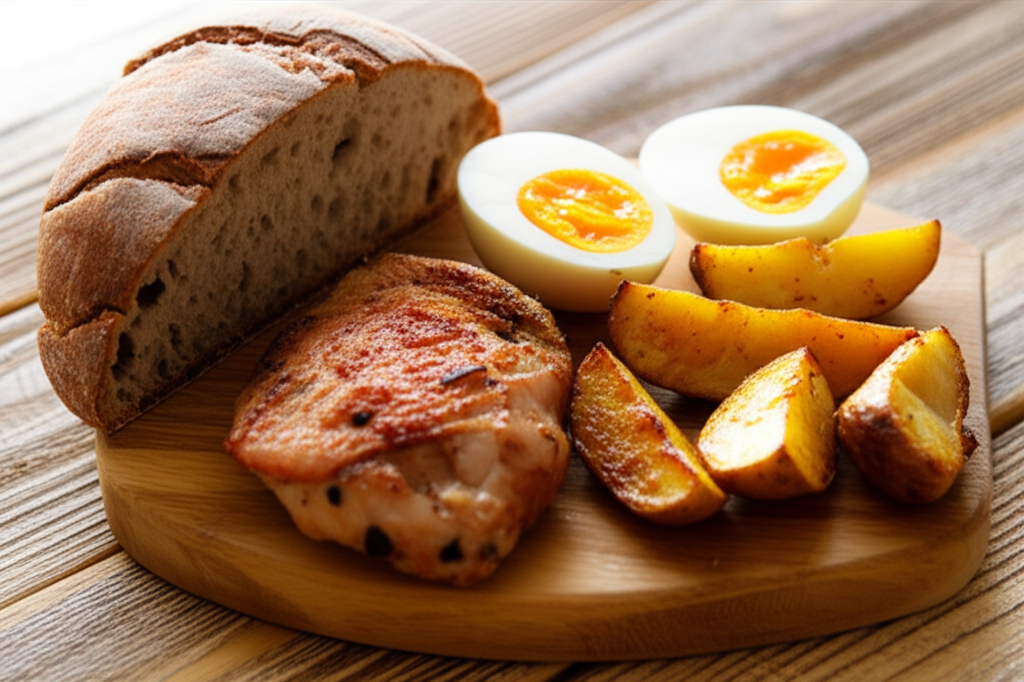

Aqui estão os textos detalhados para cada alimento, considerando a inflação, substituições econômicas e opções mais saudáveis para ganho de peso:

**1. Pão**

*   **Descrição:** O pão é um alimento básico, geralmente feito de farinha, água e fermento, consumido em diversas culturas como acompanhamento ou base para sanduíches.
*   **Inflação e Substituição Econômica:** Embora não haja dados específicos de inflação para o pão, a inflação geral de alimentos e bebidas em Abril/2025 foi de 0,82%, com um acumulado de 5,53% nos últimos 12 meses. Uma alternativa mais econômica é a tapioca, que pode gerar uma economia de 15-20%.
*   **Substituição Saudável:** Para um ganho de peso mais saudável, a aveia em flocos é uma excelente opção. Rica em carboidratos complexos e fibras, oferece um bom aporte calórico e pode ser facilmente adicionada a diversas refeições como frutas, iogurtes ou mingaus.

**2. Ovo**

*   **Descrição:** O ovo é um alimento nutritivo, rico em proteínas e gorduras essenciais, utilizado em inúmeras preparações culinárias.
*   **Inflação e Substituição Econômica:** Similar ao pão, não há dados específicos de inflação para o ovo, mas podemos considerar a inflação geral de alimentos e bebidas. A proteína de soja texturizada (PTS) surge como uma alternativa econômica, com uma economia estimada de 25-30%.
*   **Substituição Saudável:** O amendoim e a pasta de amendoim são substituições saudáveis e eficazes para ganho de peso. São ricos em calorias, proteínas e gorduras saudáveis, fáceis de consumir e versáteis para incluir na dieta.

**3. Frango**

*   **Descrição:** O frango é uma carne branca magra, rica em proteínas, amplamente consumida por ser uma opção acessível e versátil.
*   **Inflação e Substituição Econômica:** Sem dados inflacionários específicos, utiliza-se a inflação geral de alimentos. A sardinha enlatada é uma alternativa mais barata, com uma economia estimada de 20-25%.
*   **Substituição Saudável:** O salmão, embora mais caro, é uma excelente fonte de proteína e gorduras ômega 3, promovendo o ganho de massa muscular e fornecendo energia de alta qualidade.

**4. Batata**

*   **Descrição:** A batata é um tubérculo rico em carboidratos, amplamente utilizado como fonte de energia em diversas dietas.
*   **Inflação e Substituição Econômica:** A batata-inglesa teve uma inflação mensal significativa de 18,29% em Abril/2025. A mandioca se apresenta como uma alternativa mais econômica, com uma economia potencial de 30-35%.
*   **Substituição Saudável:** A batata doce é uma excelente opção para substituir a batata-inglesa, especialmente para quem busca ganho de peso saudável. É um carboidrato complexo de baixo índice glicêmico, fornecendo energia de forma gradual e rica em fibras e vitaminas.



In [11]:
final_text = agente_valida_dados(alimentos, objetivo)

if final_text == 'NÃO':
    print('Resposta inválida')
    exit

final_text = agente_verifica_ipca_alimentos(date.today(), final_text)

final_text = agente_busca_alimentos_substitutos_inflacao(date.today(), final_text)

final_text = agente_busca_alimentos_substitutos_saudaveis(final_text)

final_text = gerar_texto_final(final_text)

print('Relatório final')
mostrar_html_com_imagem_e_texto(final_text, image)

